# Analyzing muscle recordings from Drosophila larvae

### Erin C. McKiernan<sup>1</sup>, Marco A. Herrera-Valdez<sup>2</sup>

<sup>1</sup> Departamento de Física, Facultad de Ciencias, Universidad Nacional Autónoma de México <br/>
<sup>2</sup> Departamento de Matemáticas, Facultad de Ciencias, Universidad Nacional Autónoma de México <br/>

## Background
This Jupyter notebook is written to accompany our manuscript:

* McKiernan, E.C., Arce Rincón, J.H., Torres Pérez, A., & Herrera-Valdez, M.A. A method for analyzing physiological data with multiple non-independent observations. 

This manuscript analyzes two different data sets, one being Drosophila muscle recordings, and the other being human electrocardiogram recordings. Here we look only at the Drosophila data. We have a separate notebook analyzing the human data. 

The fly lines used, rearing conditions, dissection methods, and electrophysiological recording techniques have all been described previously in:

* McKiernan, E. C. (2010). The role of specific voltage-activated and calcium-activated potassium currents in shaping motor neuron firing output during rhythmic motor activity. _The University of Arizona Campus Repository_
http://hdl.handle.net/10150/145732.

* McKiernan EC. (2013). Effects of manipulating slowpoke calcium-dependent potassium channel expression on rhythmic locomotor activity in _Drosophila_ larvae. _PeerJ_ 1:e57 https://doi.org/10.7717/peerj.57 (and see Supplemental Information)

* McKiernan EC. (2015) A genetic manipulation of motor neuron excitability does not alter locomotor output in _Drosophila_ larvae. _PeerJ PrePrints_ 3:e1434 https://dx.doi.org/10.7287/peerj.preprints.469v3

Data and code for the 2015 paper were also shared previously at https://github.com/emckiernan/eki-study.

## Setting up the notebook
First, we import all the packages needed for computing, graphing, etc. We also check all our package versions.

In [9]:
from repeatedMeasures_baseCode import *
# command to view figures in Jupyter notebook
%matplotlib inline 

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 14 # fontsize for figure labels
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
#
dataPath = '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/drosophila-muscle/'

In [10]:
# run following code if you want figures centered, or comment out for default left-aligned
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [11]:
# For reproducibility purposes, print python and package versions
! python3 --version

#! pip3 install print-versions # works for python >= 3.8
#from print_versions import print_versions
#print_versions(globals())

Python 3.13.3


In [12]:
# also for reproducibility, print jupyter specs
!jupyter --version

Selected Jupyter core packages...
IPython          : 9.2.0
ipykernel        : 6.29.5
ipywidgets       : not installed
jupyter_client   : 8.6.3
jupyter_core     : 5.7.2
jupyter_server   : 2.15.0
jupyterlab       : 4.4.2
nbclient         : 0.10.2
nbconvert        : 7.16.6
nbformat         : 5.10.4
notebook         : 7.4.1
qtconsole        : not installed
traitlets        : 5.14.3


## Visualizing the recordings
We start by opening and plotting one of the Axon Binary Files. This is a dual channel recording from Drosophila muscles in adjacent body wall segments. Reading the file with the pyabf package and then printing the result will spit out several stats, including the number of channels (note that we have an empty channel, so the total number is 3), the sampling rate, and the total duration of the recording. 

In [13]:
# NOTE: THIS IS NOT THE RIGHT ABF; JUST FOR EXAMPLE
import pyabf
abf=pyabf.ABF(dataPath + "09706000.abf")
print(abf)

ABF (v1.649) with 3 channels (mV, mV, mV), sampled at 10.101 kHz, containing 1 sweep, having no tags, with a total length of 8.62 minutes, recorded with protocol "protocol2".


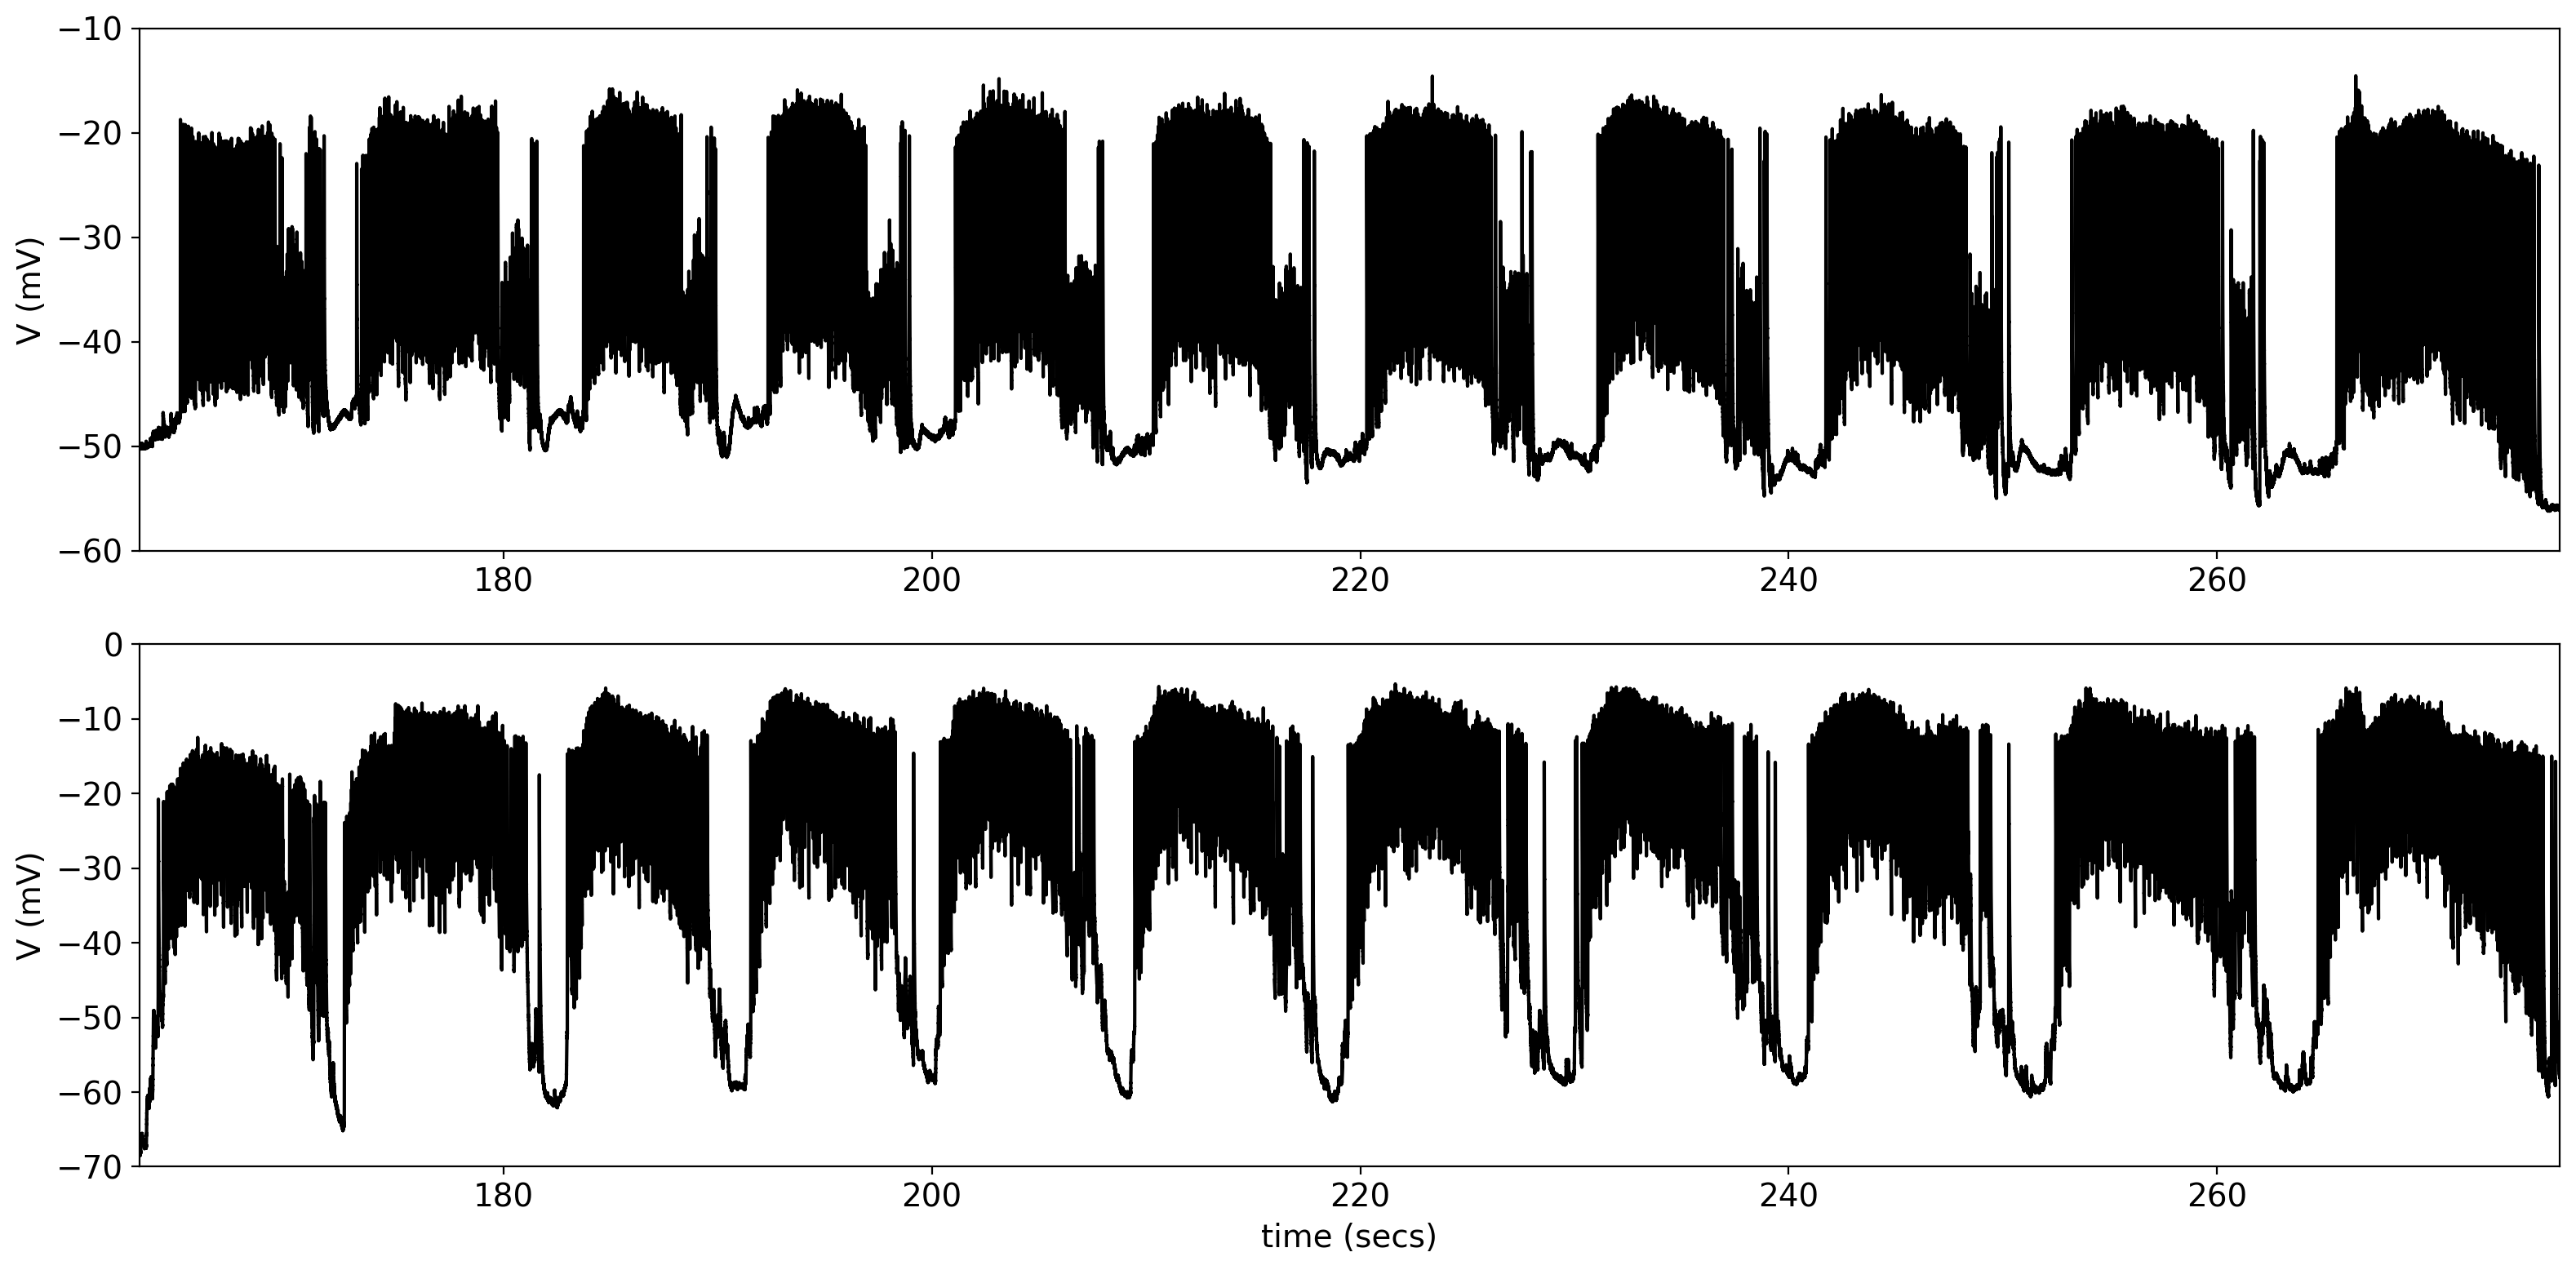

In [14]:
# set up the figure
fig,(ax1, ax2)=plt.subplots(2,figsize=(16, 8))

# plot the first channel
abf.setSweep(sweepNumber=0, channel=0)
ax1.plot(abf.sweepX,abf.sweepY,label="Channel 1",color='k')

# plot the second channel
abf.setSweep(sweepNumber=0, channel=1)
ax2.plot(abf.sweepX,abf.sweepY,label="Channel 2",color='k')

# plot labels and limits
ax1.set_ylabel('V (mV)')
ax2.set_ylabel('V (mV)')
plt.xlabel('time (secs)')
ax1.axis([163, 276, -60, -10])
ax2.axis([163, 276, -70, 0])
plt.tight_layout();

## Extracting and analyzing the burst times
As seen in the above plot, the recordings consist of repeated bursts of electrical activity, which correspond to the muscle contractions. We want to quantify temporal aspects of this activity, including:

* burst duration ('burstDur') = time elapsed from the start to the end of one burst
* cycle duration ('cycleDur') = time elapsed from the start of one burst to the start of the next burst
* duty cycle ('dutyCycle') = burst duration divided by cycle duration
* quiescence interval ('qI') = time elapsed from the end of one burst to the start of the next burst

To achieve this, bursts times were manually extracted from the raw recordings and exported to csv files corresponding to the different experimental groups (e.g. wildtype/control, WT; or mutant Slowpoke, Slo). We then specify these as the csv files we want to read and create keys for each.

In [33]:
# select csv files for analysis and create keys  
csvFiles={'WT':dataPath + 'wildtype.csv','Slo':dataPath + 'slomutant.csv'}

Next, we create a function to read the csv files row by row, with each row including all the burst times for one subject. Running the function for the csv file keys we specified above gives us all the data for each group. We can print the data by group just to be sure the extraction is working correctly.   

In [34]:
# extract burst times for each group and place in dictionary with corresponding group keys
data=dict()
for k in csvFiles.keys():
    print('%s:\n'%k)
    data[k]=getCSVData(csvFiles[k])
    for n in np.arange(0,len(data[k])):
        print('%d:'%n, data[k][n], '\n')
    print('\n--------------------\n')

WT:

0: [203.32, 208.56, 214.25, 221.68, 225.68, 233.38, 237.25, 245.68, 249.69, 257.43, 262.26, 271.73, 276.56, 284.44, 289.09, 297.83, 302.52, 309.26, 313.63, 320.69, 324.75, 331.81, 337.14, 343.65, 347.7, 354.9, 359.55, 365.97] 

1: [167.41, 172.76, 175.53, 180.09, 181.79, 187.13, 188.8, 194.18, 195.6, 201.01, 202.36, 208.25, 209.57, 214.51, 216.17, 221.21, 222.69, 227.97, 229.26, 234.64, 235.99, 240.68, 242.07, 248.33, 249.59, 254.08, 255.25, 259.94, 261.23, 265.32, 267.05, 271.14, 272.68, 277.34, 278.47, 282.97, 284.26, 289.29, 290.55, 295.55, 296.75, 302.19, 303.48, 309.27, 310.43, 316.35, 317.61, 322.45, 324.21, 328.71, 330.29, 334.38, 335.89, 340.26, 341.74, 345.36, 346.93, 351.08, 352.4, 357.59, 358.95, 362.53, 364.3, 368.48, 370.27, 374.93, 376.97, 382.2, 384.27, 388.99, 391.79, 395.25, 397.64, 402.11, 403.94, 409.38, 412.02, 416.46, 419.1, 423.13, 426.59, 429.23, 433.17, 437.7, 440.43, 443.52, 446.5, 450.44, 453.58, 455.94, 459.72, 462.46, 465.07, 467.9, 473.09, 476.11, 478.

We can also graph the burst start and end times for each subject in each group, as extracted, to get a visual representation of the data. Note that bursting bouts begin and end at different times in the recording for each subject, thus the variable position of each 'train' along the x axis. The graph clearly shows one of the main issues with data sets like this one, namely that we have repeated measures for each subject, but that the number of measures (in this case, bursts) varies widely across subjects.

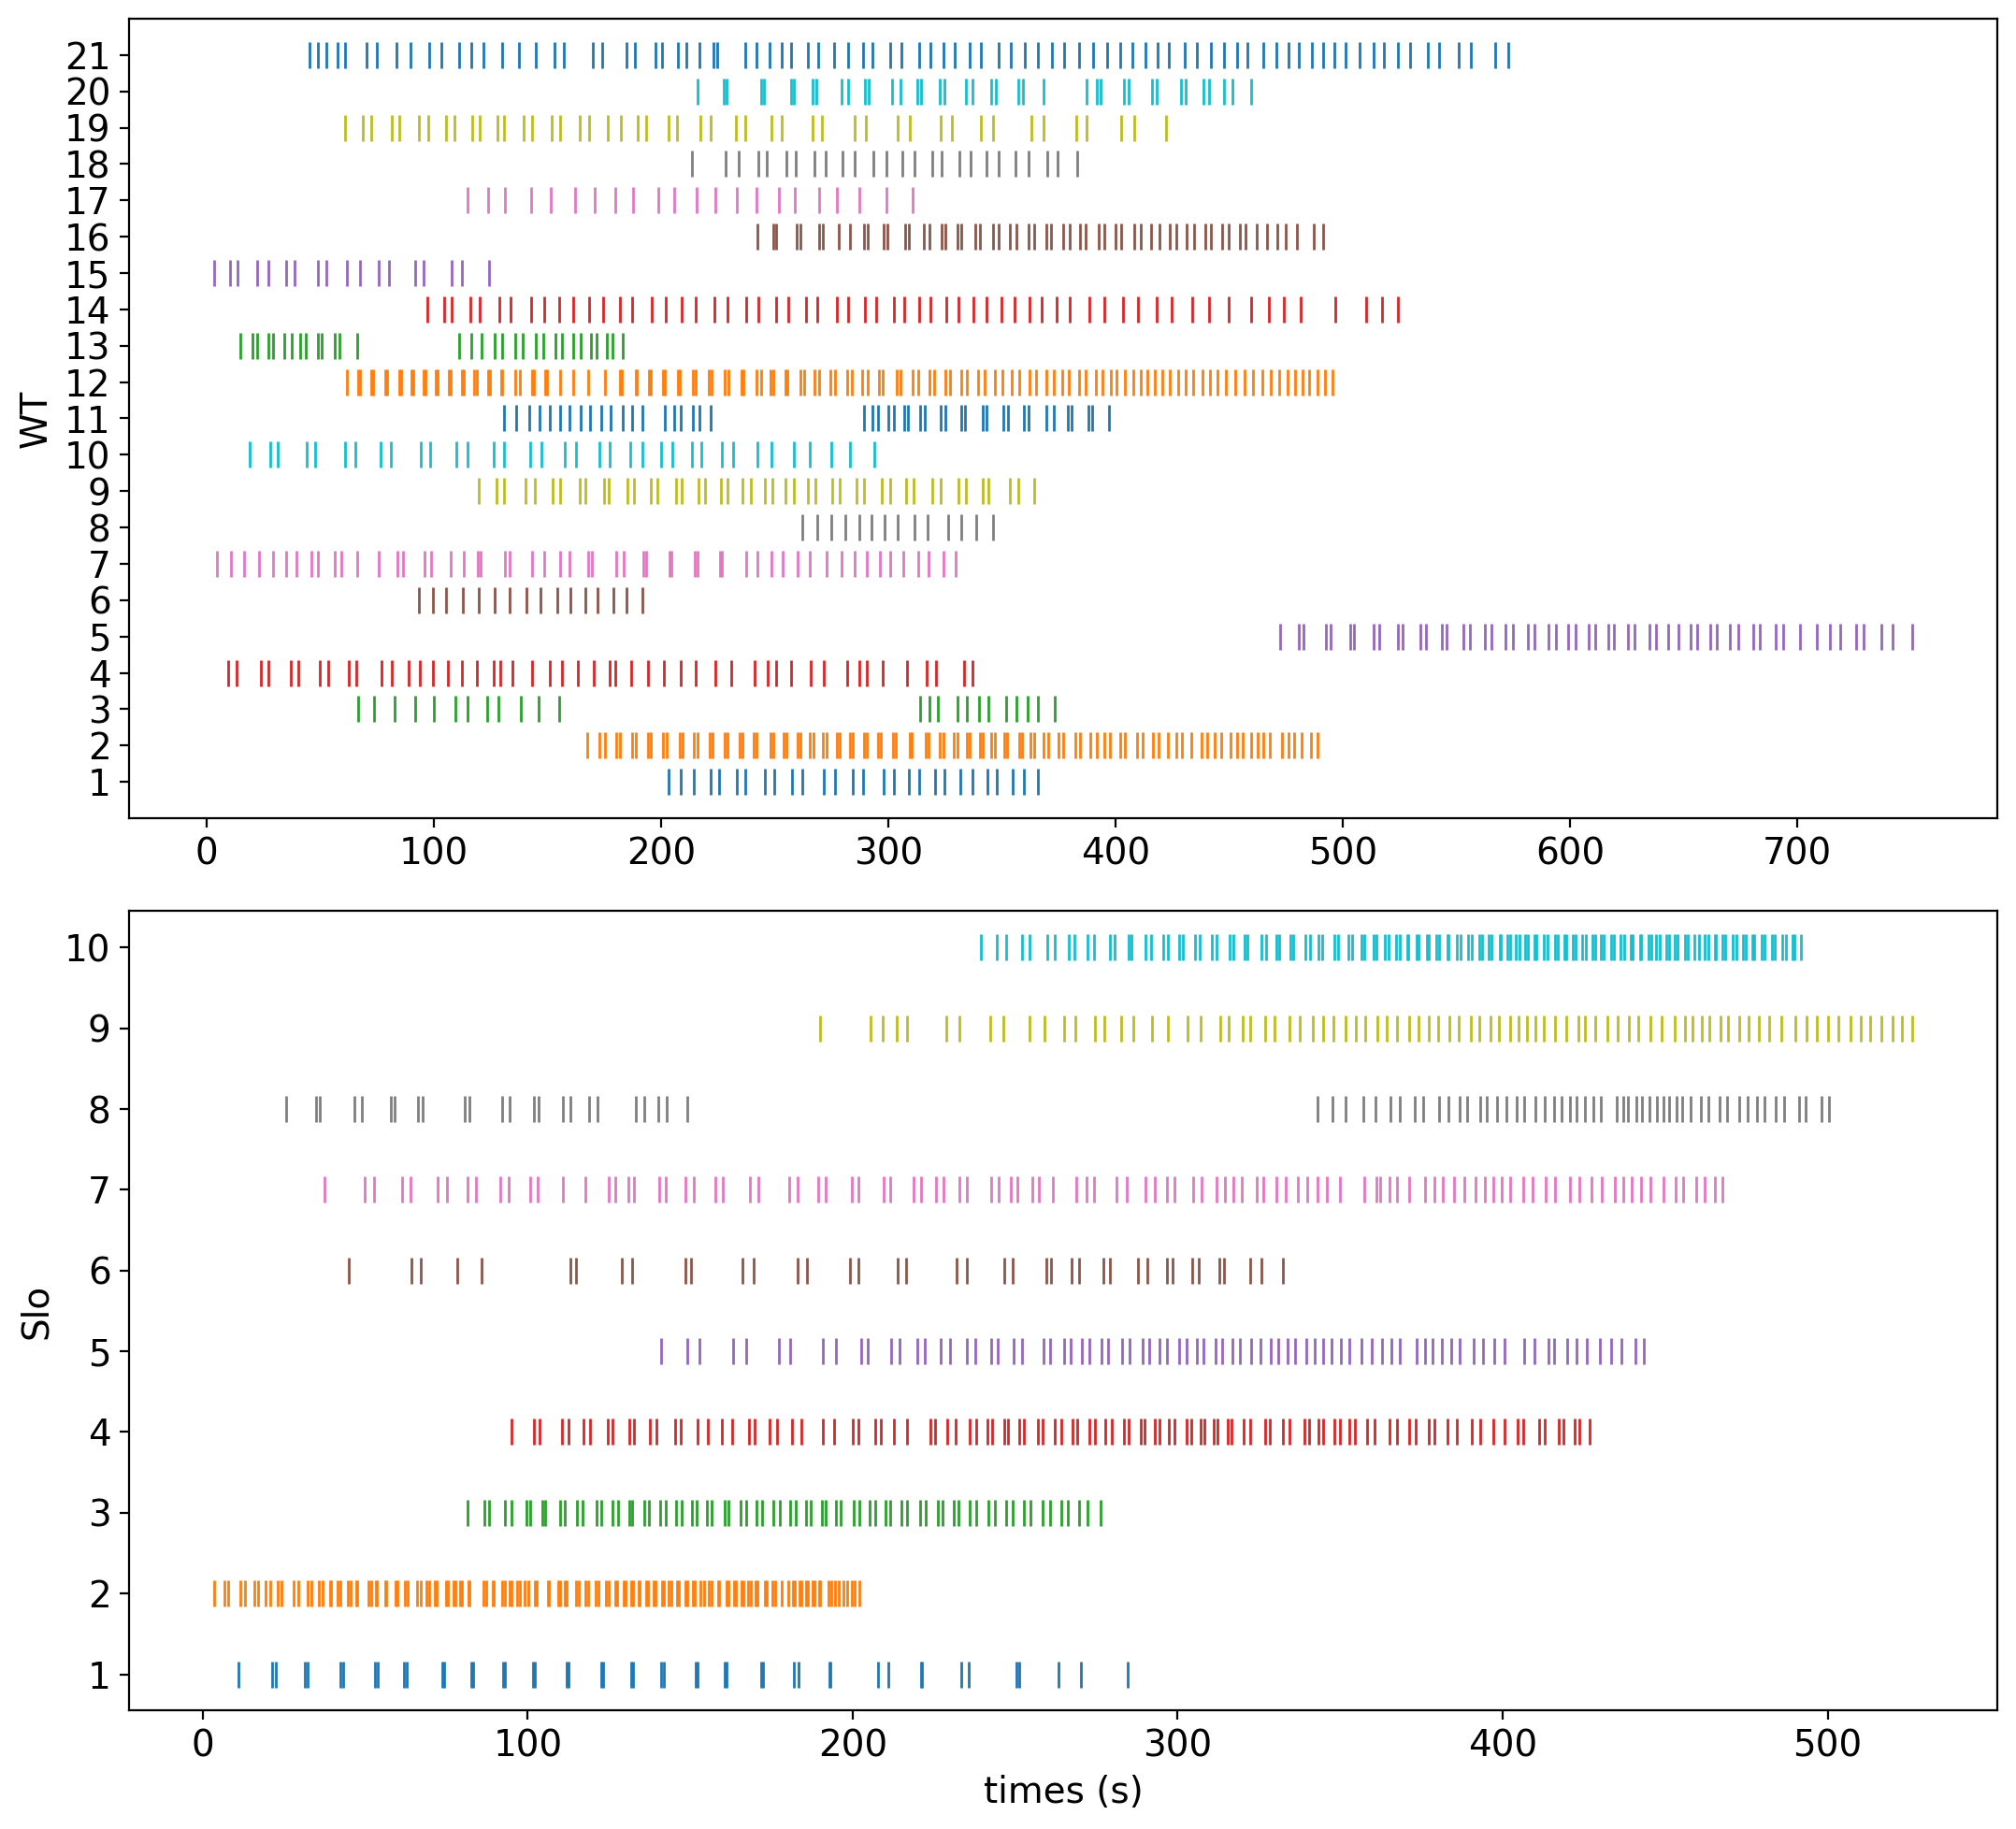

In [35]:
# graph burst start and end times for each subject from each group
keys = data.keys()
f = plt.figure(figsize=(11,10))
ax=list(); r = 2; c = 1; plt.ioff()
pp = 0
for k in keys:
    dd = data[k]
    nTrains = len(dd)
    ax.append(f.add_subplot(r,c,pp+1));
    for n in range(nTrains):
        nPts = len(dd[n])
        ax[pp].plot(dd[n],(n+1)*np.ones(nPts),'|',markersize=10)
    ax[pp].set_ylabel(k)
    ax[pp].set_yticks(np.arange(1,len(data[k])+1,1))
    pp+=1
ax[1].set_xlabel('times (s)')
plt.ion();
plt.tight_layout()

Now that we have the burst times, we define and run a function to calculate all the burst measures for each group. We're going to focus on cycle duration in this notebook, but the analyses could be repeated for any burst measure.

In [36]:
# function to calculate burst measures from one data set
def calcBurstMeasures(data):
    measures=dict()
    nrows=len(data)
    burstStarts=list()
    burstStops=list()
    burstDurs=list()
    cycleDurs=list()
    burstFreqs=list()
    dutyCycles=list()
    qIs=list()

    for n in range(0,nrows):
        nBursts = len(data[n])
        burstStarts.append(np.array(data[n][0::2]))
        burstStops.append(np.array(data[n][1::2]))
        # burst duration - time elapsed from start to end of one burst
        burstDurs.append(burstStops[n]-burstStarts[n])
        # cycle duration - time elapsed from start of one burst to start of next
        cycleDurs.append(np.diff(burstStarts[n]))
        # duty cycle - burst duration divided by cycle duration
        dutyCycles.append(burstDurs[n][:-1]/cycleDurs[n])
        # quiescence interval - time elapsed from end of burst to start of next
        qIs.append(burstStarts[n][1:]-burstStops[n][:-1])
        if 0:
            print('Burst durations:') 
            print(burstDurs[n])
            print('Cycle durations:') 
            print(cycleDurs[n])
            print('Duty cycles:') 
            print(dutyCycles[n])
            print('Quiescence intervals:') 
            print(qIs[n])
            print('\n')
        
    measures={'burstDur':burstDurs,
              'cycleDur':cycleDurs,
              'dutyCycle':dutyCycles,
              'qI':qIs}
    return measures

In [37]:
# recalculate all burst measures, just to make sure we have all observations from all subjects
def recalculateBurstMeasures():
    bMeasures = dict()
    cycleDurs = dict()
    for k in data.keys():
        bMeasures[k] = calcBurstMeasures(data[k])  
        cycleDurs[k] = bMeasures[k]['cycleDur']
    return bMeasures, cycleDurs

#cycleDurs[k] = bMeasures[k]['cycleDur']
bMeasures,cycleDurs = recalculateBurstMeasures()
#print(cycleDurs)


#cycleDurs = dict()
#for k in data.keys():
#    # change keys below to print data for different groups or burst measures
#    print('%s:\n0'%k)
#    cycleDurs[k] = bMeasures[k]['cycleDur']
#    for n in np.arange(0,len(cycleDurs[k])):
#        siz = len(cycleDurs[k][n])
#        # print sample size and cycle durations for each subject in each group
#        print(siz, ' cycleDurs:', cycleDurs[k][n])
#    print('\n------------\n')

We can see in the left column above that the sample sizes (i.e. number of bursts) vary widely across subjects. To examine this further, we can save all the sample sizes, and then look at the minimum, maximum, and difference between these to see how uneven the weighting of subjects in the sample might be.

In [38]:
# print number of cycle durations for each subject in given group
sampleSizes=[]
for n in np.arange(0,len(bMeasures['WT']['cycleDur'])):
    numCDs=len(bMeasures['WT']['cycleDur'][n])
    sampleSizes.append(numCDs)

print(sampleSizes)

[13, 49, 11, 24, 27, 7, 27, 6, 22, 17, 22, 62, 15, 30, 8, 29, 10, 12, 23, 19, 43]


In [39]:
# print minimum sample size, max, difference between the two, and the fold difference
minn=min(sampleSizes)
maxn=max(sampleSizes)
diffn=maxn-minn
timesn=maxn/minn

print(minn)
print(maxn)
print(diffn)
print(round(timesn, 2))

6
62
56
10.33


In this WT (control) sample, the subject with the smallest number of bursts has only 6, while the subject with the largest number has 62, representing a more than ten-fold difference. This will be important later when we look at how data is handled, i.e. pooled or not pooled.

## Defining functions
Before we can analyze the data we set up two classes, one with functions that deal with a single sample (i.e. bursting data from one subject) and a second class with functions that deal with multiple samples. The overall focus of our analysis is on calculating the empirical distribution function (EDF) of the samples. The EDF "can be used to describe a sample of observations of a given variable. Its value at a given point is equal to the proportion of observations from the sample that are less than or equal to that point" (https://www.statlect.com/asymptotic-theory/empirical-distribution). The EDF "is an estimate of the cumulative distribution function that generated the points in the sample" (https://en.wikipedia.org/wiki/Empirical_distribution_function). Our strategy (explained in more detail in our accompanying paper) is to first calculate the EDF for a single subject from a single group (e.g. WT or Slo). Then, we average over those EDFs to generate the group EDF. We will look at this in more detail in the sections below. First, we define a few auxiliary functions, and then the class functions. 

## Examining issues with pooling data
Many studies that deal with this type of repeated measures data end up pooling observations from multiple subjects together for analysis. So, let's begin by doing that to examine the effects. In other words, we will dump all cycle durations from the WT subjects into a single list, and the same for the Slo group. We can then plot histograms of the pooled data to compare.

In [40]:
# gather all observations from WT and Slo subjects into single lists (i.e. pool)  
RM = dict(); #print(cycleDurs.keys())
for k in cycleDurs.keys():
    RM[k] = RepeatedMeasures(sampleList=cycleDurs[k])

cds_wt = RM['WT'].pooled.sample_pts
cds_slo = RM['Slo'].pooled.sample_pts

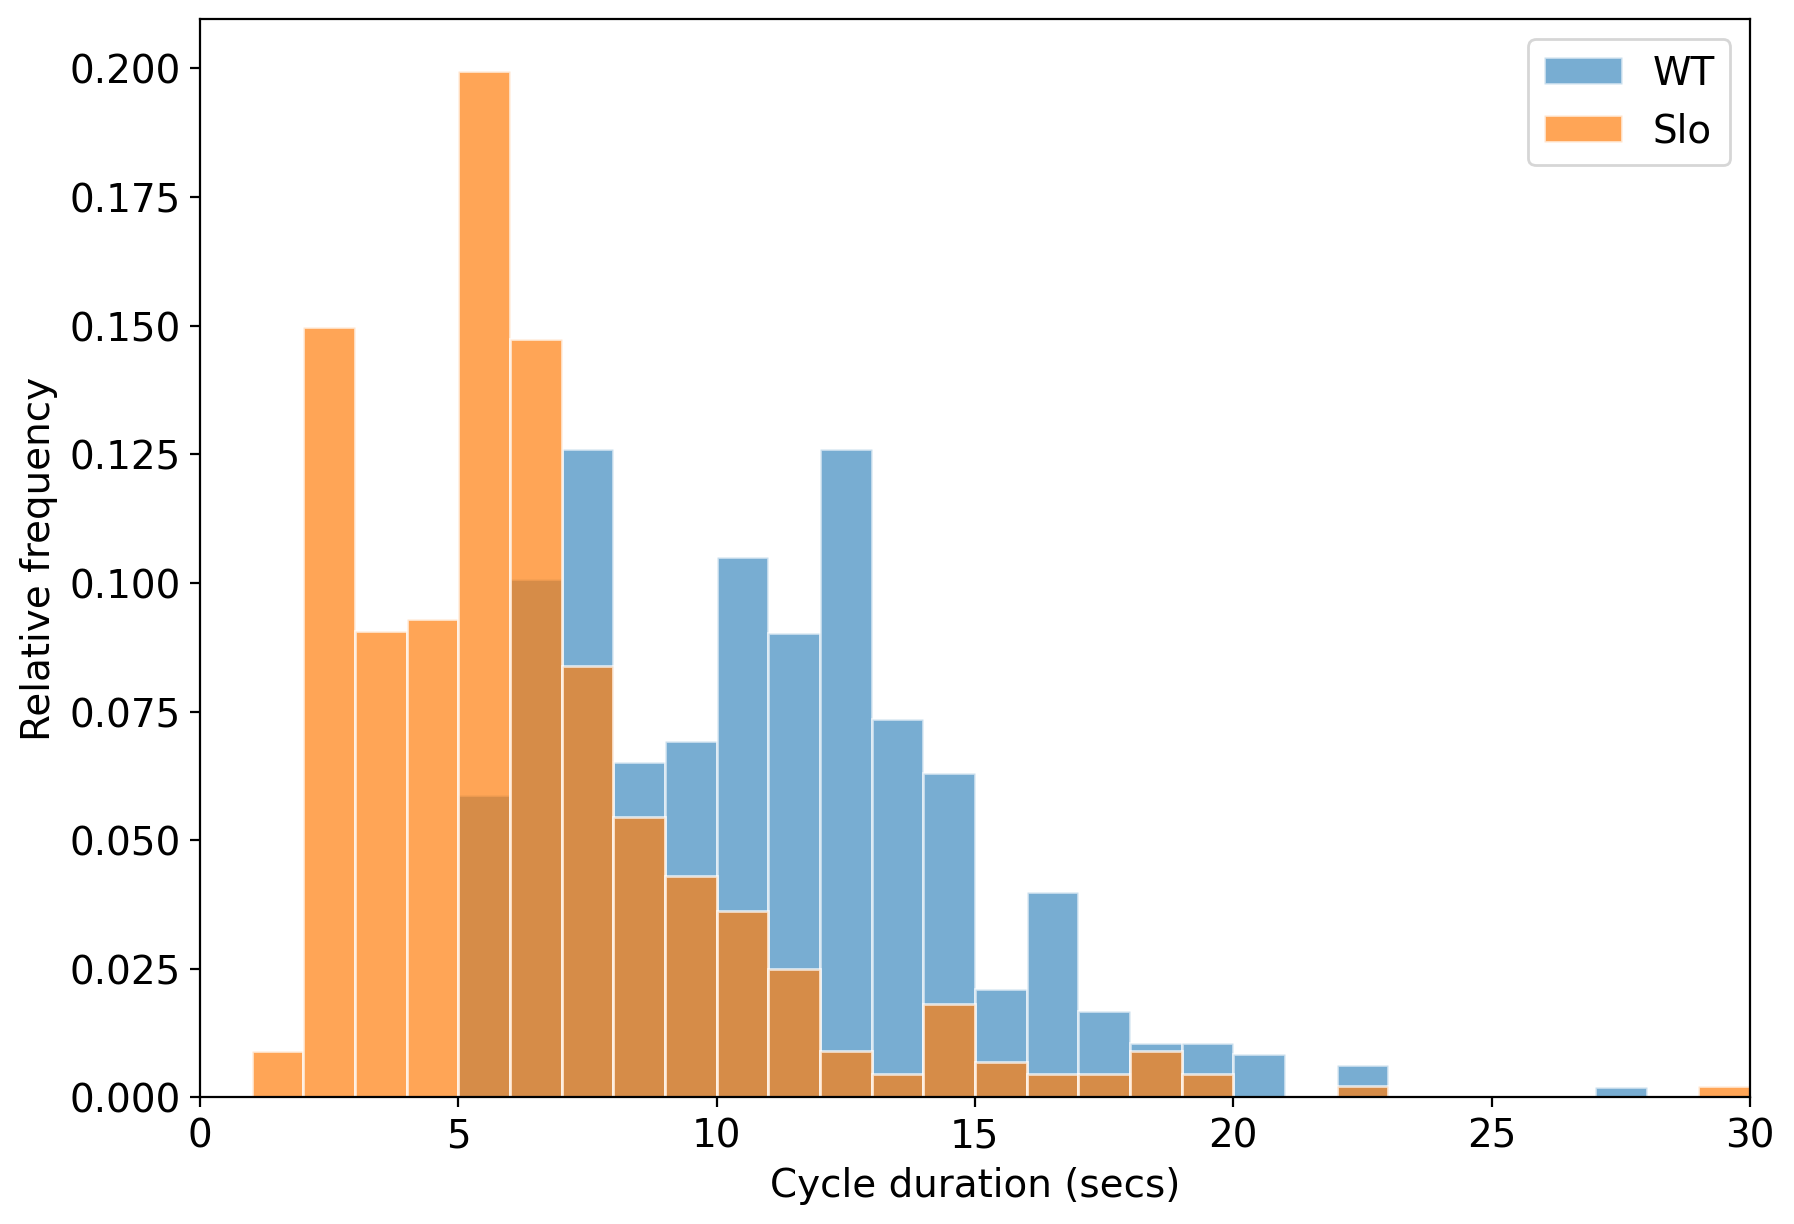

In [41]:
# plot overlapping histograms to compare the two groups with pooled observations
plt.figure(figsize=(10,7))
plt.hist(cds_wt,weights=np.zeros_like(cds_wt) + 1. / cds_wt.size, bins=range(50),fill=bool,\
         linewidth=1.0,edgecolor='white',label='WT',alpha=0.6)
plt.hist(cds_slo,weights=np.zeros_like(cds_slo) + 1. / cds_slo.size,bins=range(50),fill=bool,\
         linewidth=1.0,edgecolor='white',label='Slo',alpha=0.7)
plt.xlim(0,30)
plt.xlabel('Cycle duration (secs)')
plt.ylabel('Relative frequency')
plt.legend();

From the above graphs, we can see that there is a clear shift in the Slo distribution relative to WT. But since we know some subjects have widely varying numbers of observations, how much of an issue is it to pool these? To understand the potential problems with this approach, we will look just at the WT data. To get an idea of the shape, spread, and contribution of each subject to the WT sample, we can plot their kernel density estimate (KDE), which is essentially a smoothed version of the relative frequency histogram. (We are here looking only at cycle duration, but this can be done for any burst measure.)

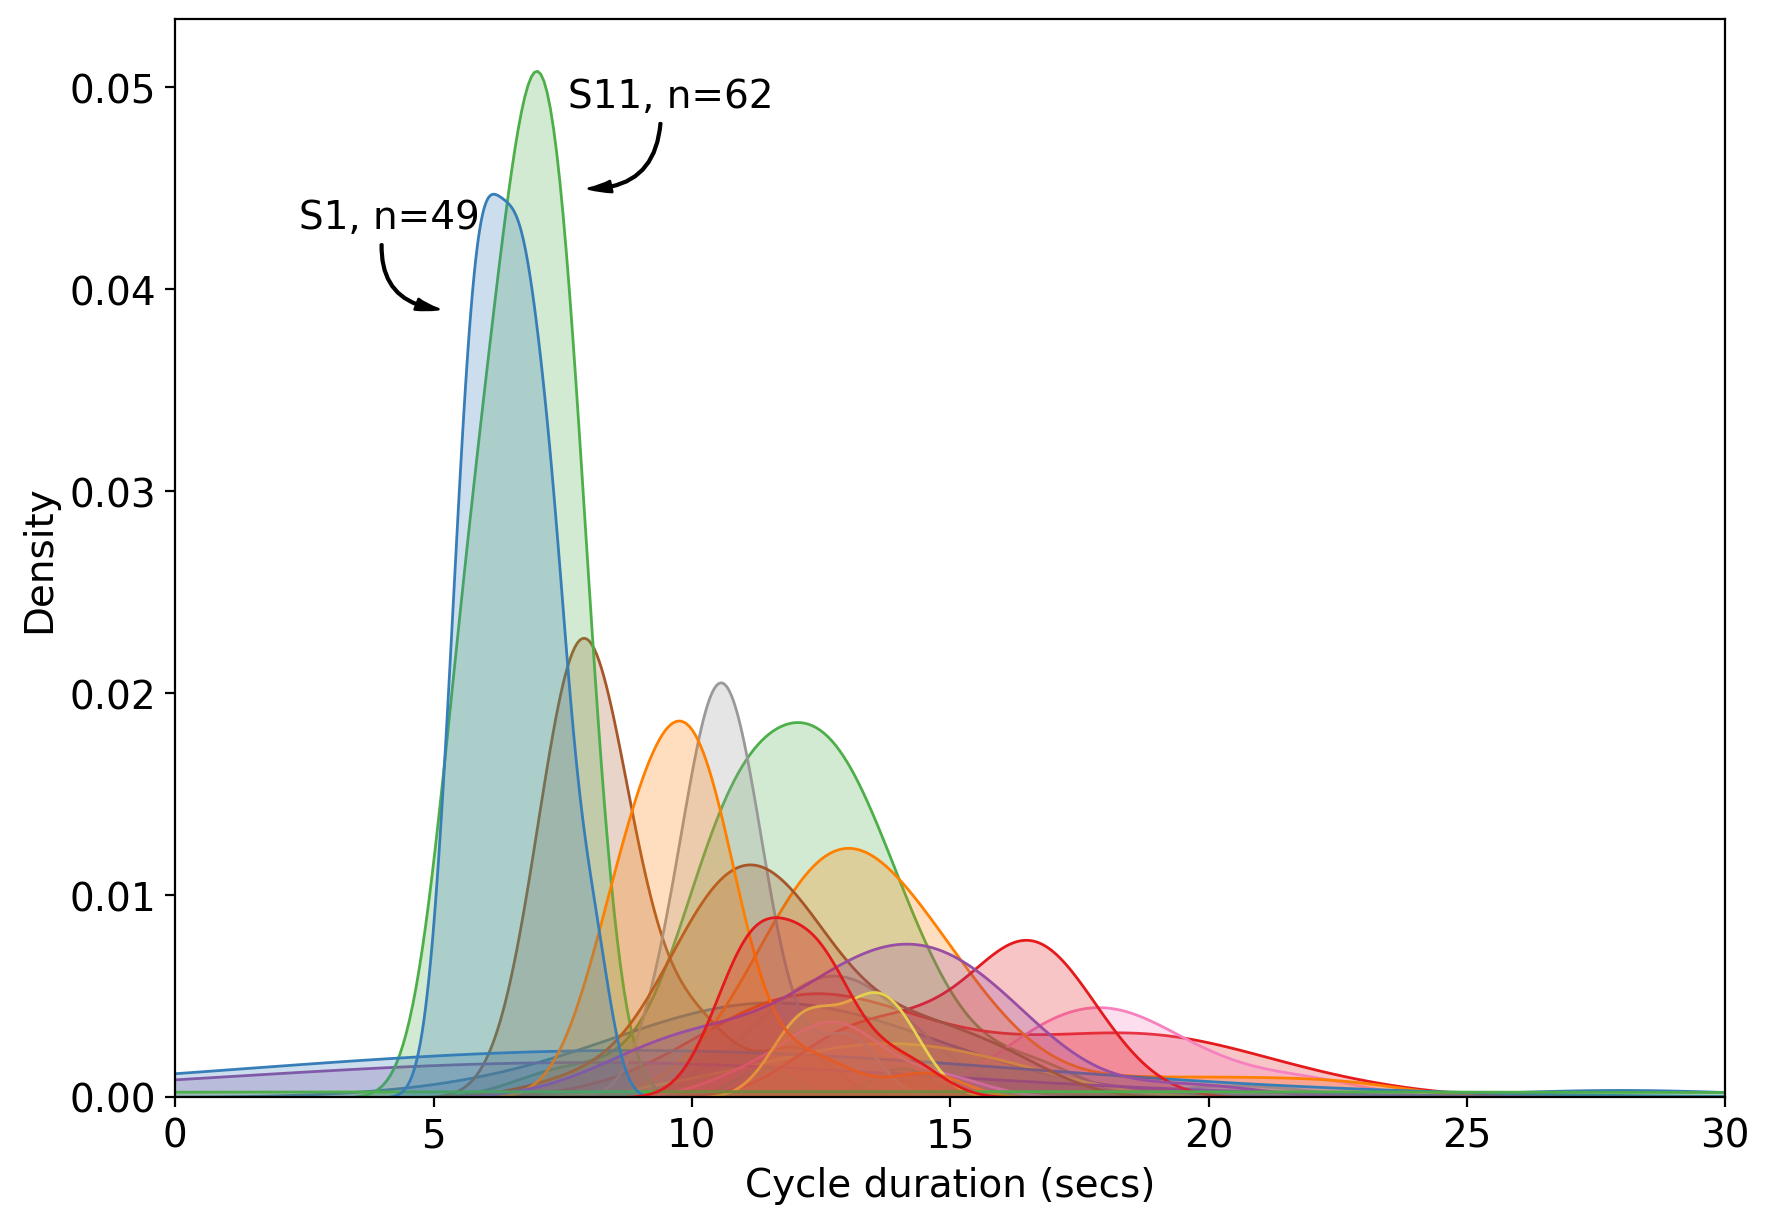

In [44]:
# plot the KDEs for each WT subject
plt.figure(figsize=(10,7))
sns.kdeplot(bMeasures['WT']['cycleDur'],fill=bool,legend=False,linewidth=1.0,palette="Set1")

plt.annotate('S1, n=49',xy=(2.4,0.043),fontsize=14)
plt.annotate('S11, n=62',xy=(7.6,0.049),fontsize=14)

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
a = patches.FancyArrowPatch((4.0,0.0425),(5.2,0.039),connectionstyle="arc3,rad=.5",**kw)
b = patches.FancyArrowPatch((9.4,0.0485),(7.9,0.045),connectionstyle="arc3,rad=-.5",**kw)
plt.gca().add_patch(a)
plt.gca().add_patch(b)

plt.xlabel('Cycle duration (secs)')
plt.xlim(0,30);

We can see that the distributions for the different subjects vary widely in terms of their position on the x axis, spread, skew, etc. In particular, there are two peaks, marked with text labels and arrows, that look markedly different from the other KDEs with respect to their size and their skew towards lower values. If we look back to earlier in the notebook when we printed out the number of cycle durations for each subject, these peaks correspond to subject 1 (S1) with 49 cycle durations (n=49) and S11 with 62 cycle durations (n=49). (In terms of the subject numbers, remember that Python indexing starts at 0, so S1 would be the second subject in the sample and S11 would be the 12th.) These are the two subjects in the WT sample with the largest numbers of observations, and so could potentially pull the overall distribution to the left if we simply pool observations. To test this, we can remove these subjects from the dataset, and then graph the histograms with and without those subjects. 

In [43]:
# remove S1 and S11 data; run this in reverse to remove the correct subjects, and *ONLY RUN ONCE*
# print length of list, should be 19 corresponding to the original sample (n=21) minus two subjects
myList=bMeasures['WT']['cycleDur']
bMeasures, cycleDurs = recalculateBurstMeasures()
indexes = [1, 11]
for index in sorted(indexes, reverse=True):
    del myList[index]
    
print(len(myList))

19


In [26]:
# gather all observations from WT subjects into a single list (i.e. pool)  
RM = dict()
for k in cycleDurs.keys():
    print('Gathering samples from %s'%k)
    RM[k] = RepeatedMeasures(sampleList=myList)

cds_wt_restr=RM['WT'].pooled.sample_pts

Gathering samples from WT
Gathering samples from Slo


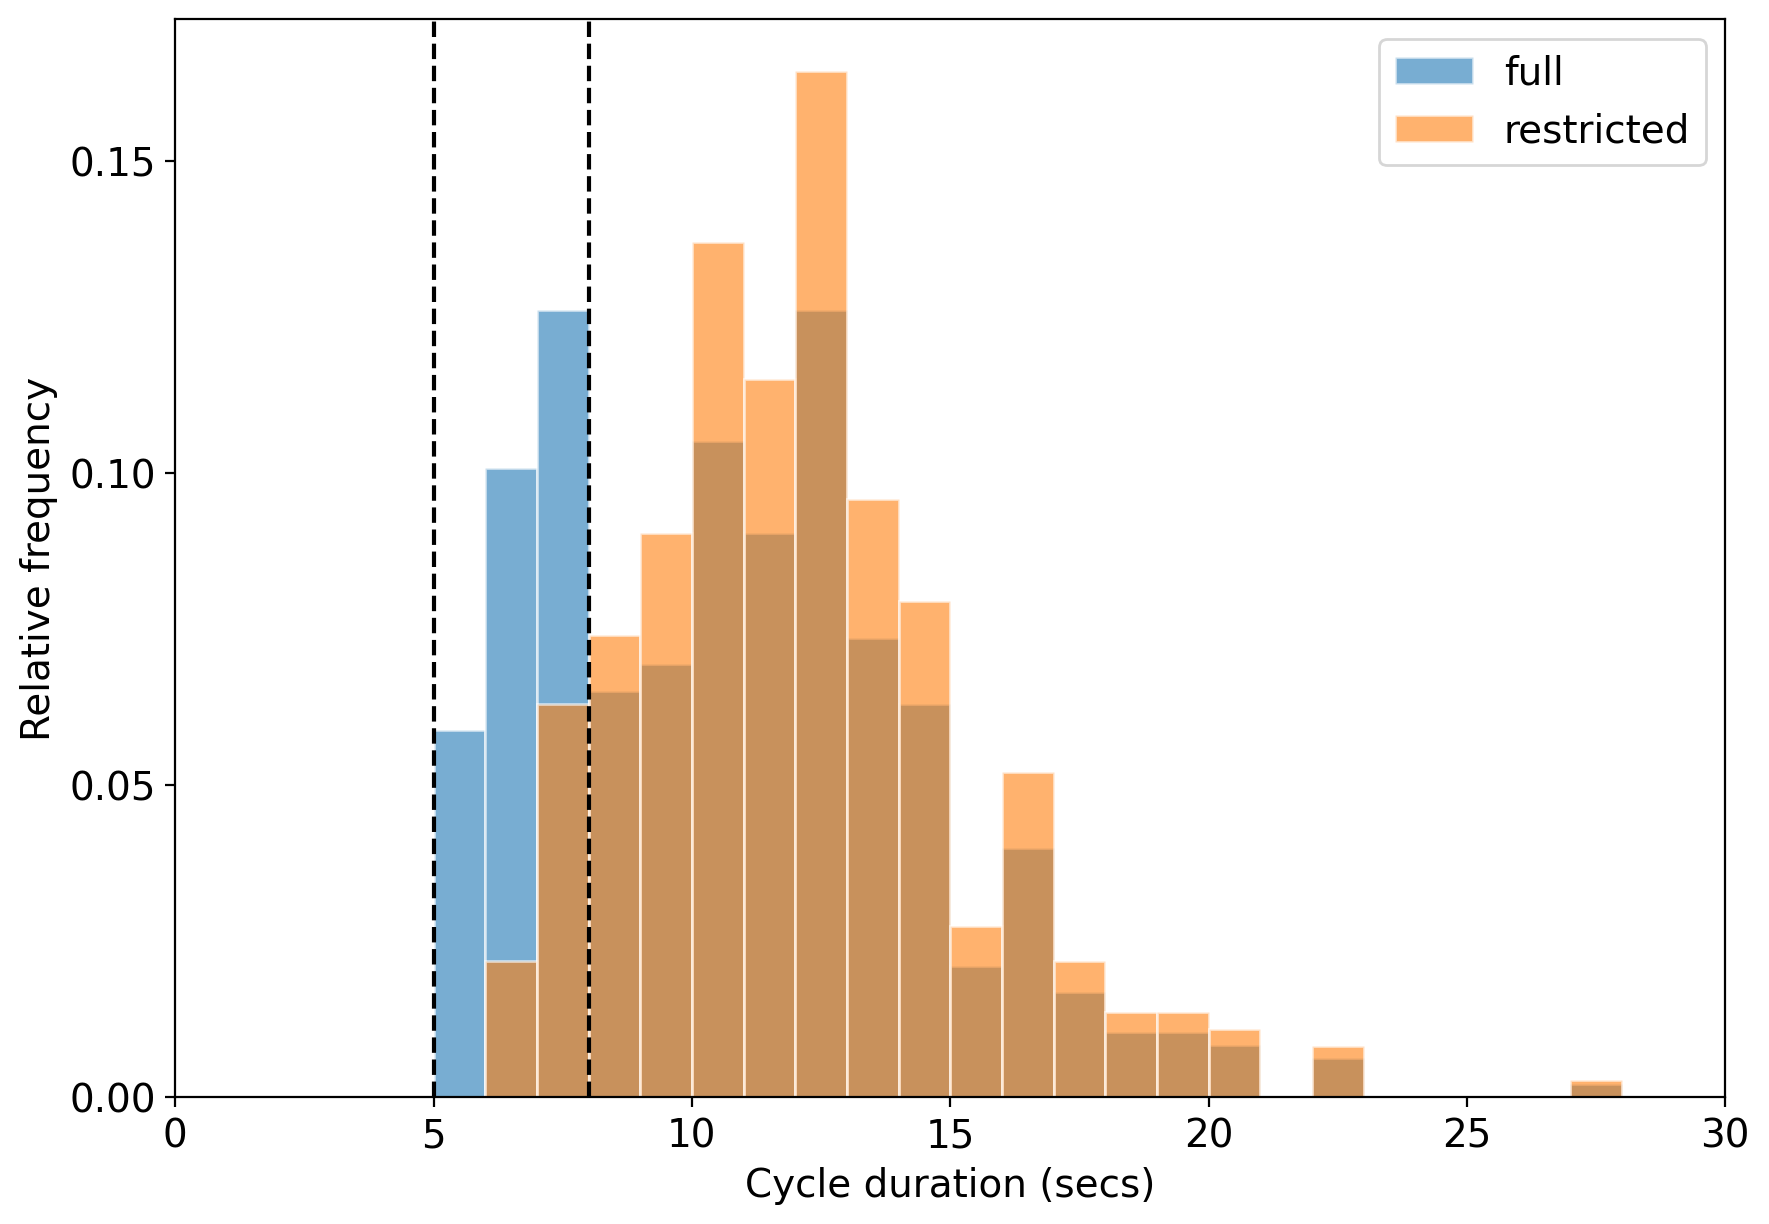

In [45]:
# plot overlapping histograms to compare the two groups with pooled observations
plt.figure(figsize=(10,7))
plt.hist(cds_wt,weights=np.zeros_like(cds_wt) + 1. / cds_wt.size,bins=range(50),fill=bool,\
         linewidth=1.0,edgecolor='white',label='full',alpha=0.6)
plt.hist(cds_wt_restr,weights=np.zeros_like(cds_wt_restr) + 1. / cds_wt_restr.size,bins=range(50),fill=bool,\
         linewidth=1.0,edgecolor='white',label='restricted',alpha=0.6)
plt.axvline(x=5,color='k',ls='--')
plt.axvline(x=8,color='k',ls='--')
plt.legend()
plt.xlim(0,30)
plt.yticks(np.arange(0,0.17, step=0.05))
plt.xlabel('Cycle duration (secs)')
plt.ylabel('Relative frequency');
plt.legend();

The graphs show that there are several large left-hand peaks in the distribution that disappear when subjects S1 and S11 are removed from the sample. This is not to suggest that we should remove these subjects from all analyses (we'll put them back in later). Rather, it demonstrates how pooling data, especially when we have subjects with large and disparate numbers of observations, can skew the distribution.

## Calculating and graphing empirical distribution functions
If we should not pool the data, what approach can we take? As we mentioned above, our strategy (described in more detail in the accompanying paper) is to first calculate the EDF for a single subject from a single group (e.g. WT or Slo). Then, we take the point-wise average over those EDFs to generate the group EDF. This helps us to avoid pseudoreplication, as each subject is represented only once, and minimizes the effect of any subjects with large numbers of observations. Then, we can properly compare the two groups. But first, we recalculate all the burst measures to make sure we've put back the subjects we removed above, and once again have a complete data set. 

In [28]:
bMeasures, cycleDurs = recalculateBurstMeasures()

In [29]:
"""For checking and debugging, print WT sample size, i.e. number of subjects. 
If not 21, subjects were removed. Must rerun to 'reset' sample."""
len(cycleDurs['WT'])

21

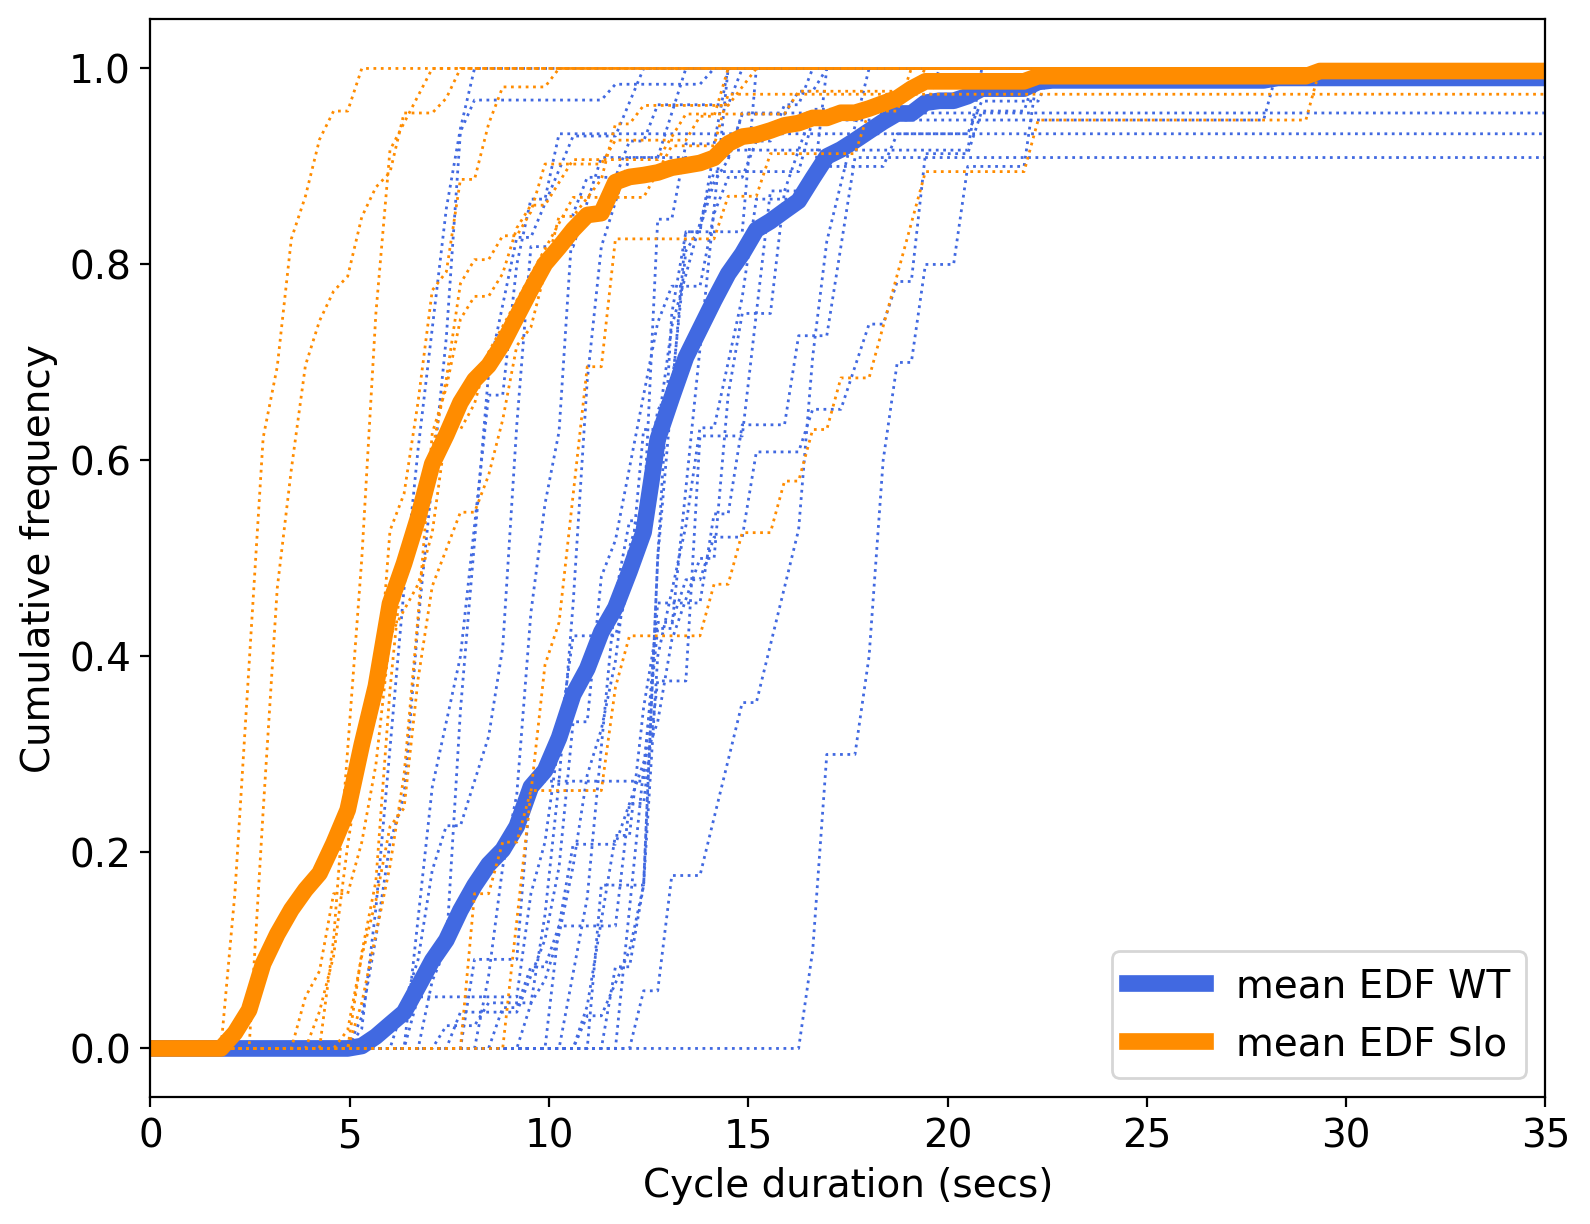

In [30]:
# calculate and plot EDFs for the two groups with n points for 'interpolation'
colors={'WT':'royalblue','Slo':'darkorange',}
minCycDur=0; maxCycDur=35; nPts=100; commonDomain = np.linspace(minCycDur,maxCycDur,nPts)
fig=plt.figure(figsize=(9,7))
ax1= fig.add_subplot(111)
G = dict();
for k in cycleDurs.keys():
    nSamples = len(cycleDurs[k])
    str0=k
    G[k]= RepeatedMeasures(cycleDurs[k])
    G[k].label= k
    G[k].domain = commonDomain
    mean_EDF_values, mean_EMF_values =\
    G[k].graph_meanEDF(ax=ax1,nPts=100,sampleColor=colors[k], meanColor=colors[k],graph=1)
    ax1.set_xlabel('Cycle duration (secs)')
    ax1.set_ylabel('Cumulative frequency')
    ax1.set_xlim(0,maxCycDur)
    #ax1.legend(loc='lower right');

In the above graph, we can see each of the individual subject EDFs (thin, dotted lines) and the average EDFs for each group (thick, solid lines). There is a clear left-shift in EDFs (individual and average) for the Slo group, i.e. the cycle durations are generally shorter than in WT. The difference looks large, but let's explore how we would formally test this.

## Performing statistical testing
Now, we want to test whether the observed difference between the two groups (WT and Slo) on the burst measure of interest (cycle duration) is statistically significant. To do this, we first pull the values from the group (averaged) EDF curves, which will be the values that go into our statistical test. Because the data distributions are non-normal, we use a non-parametric test, the Wilcoxon rank sum test. For more information on why we selected this test, please see the details and citations in our accompanying paper.

Since our technique relies on a form of boostrapping or interpolation - extracting values from the group EDFs - we can run a sensitivity test to see how the number of extracted values affects the result. To do this, we set the theoretical sample size between 2 and 40 values, increasing in steps of 1. We then use a random number generator to extract that number of values but at different points along the group EDFs. We run the statistical tests on these samples, and repeat the process 10 times for each sample size. Graphing the result lets us see how many of these tests hit below the established threshold for significance, p<0.05.

In [31]:
# set the samples to be compared and print sample sizes
WT_samples = cycleDurs['WT']; nWT = len(WT_samples); print('%d WT cycleDuration samples'%nWT)
Slo_samples = cycleDurs['Slo']; nSlo = len(Slo_samples); print('%d Slo cycleDuration samples'%nSlo)

21 WT cycleDuration samples
10 Slo cycleDuration samples


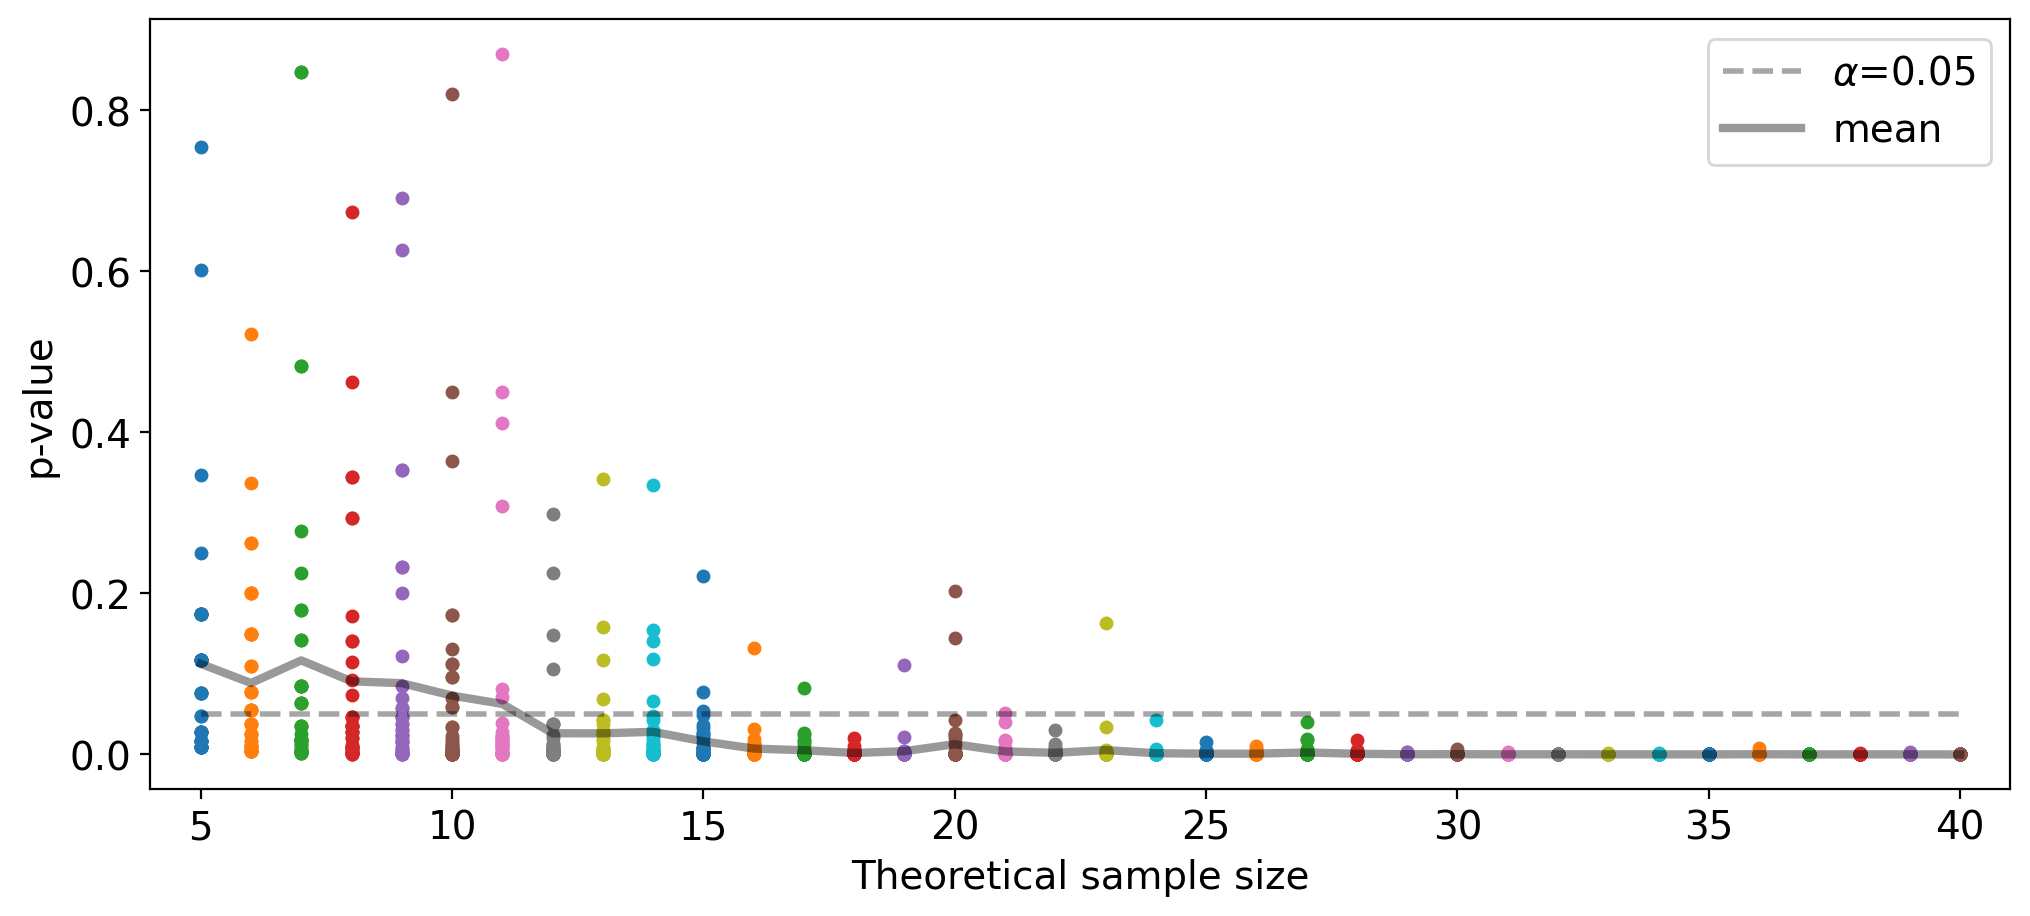

In [32]:
WRS_pval= meanEDF_WRST_sensitivity(G1=WT_samples, G2=Slo_samples, Ns = np.arange(5,41,1), repeats=40, plotResults=1)

The above figure shows that with small theoretical sample sizes, there is large variability in the resultant p-values. However, the variability decreases as the sample size increases, and once it hits around 20, the p-values tend to be below 0.05.